## OpenStreetMap Data Case Study: Udacity’s Data Analyst Nanodegree, Project 3

This notebook documents the code used in this project. It is accompanied by a shorter report which focuses on the results, largely excluding the code used. 

## Code

In [158]:
import xml.etree.cElementTree as ET
import operator
from collections import defaultdict
import re
import pprint
import codecs
import copy

#### As the original file is very large (>2 GB), I will take every 40th element to reduce the file size.

In [147]:
OSM_FILE = "london_england.osm" 
SAMPLE_FILE = "sample_production.osm"

k = 40 # take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')


### Section 1: Data Auditing and Cleaning
Investigate the most common tags in the dataset. As the file is large I will be using the iterparse method from ElementTree to parse the XML file.

In [148]:
# Define a helper function to print 20 most common tags. 
# Cannot sort by dictionary values, therefore, create a list of tuples
def print_value_sorted_dict(d):
    ## Reference
    ## http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
    sorted_d = sorted(d.items(), key = operator.itemgetter(1))
    print sorted_d[-20:]    

tag_types = defaultdict(int)
for event, elem in ET.iterparse (SAMPLE_FILE):
    if elem.tag == 'tag':
        tag_types[elem.attrib['k']] += 1
print_value_sorted_dict(tag_types)


[('note', 1699), ('ref', 1746), ('landuse', 1831), ('source:building', 1890), ('foot', 2092), ('operator', 2154), ('surface', 2294), ('barrier', 2627), ('lit', 2733), ('amenity', 2872), ('addr:city', 2924), ('maxspeed', 2959), ('natural', 3859), ('addr:street', 5329), ('addr:housenumber', 5621), ('created_by', 6417), ('source', 12896), ('name', 13067), ('building', 16914), ('highway', 17564)]


#### For the most common tag values above, I will investigate the attribute values to understand the data cleaning tasks required. 
Create a defaultdict to store values and frequencies.
What is in each defaultdict below?
- Highway: Compile a defaultdict with the values and frequency of each value.
- Building: Compile a defaultdict with the values and frequency of each value.
- Street: Run a regular expression on the end of the string and check that the names have been standardised.
- Source: Compile a defaultdict with the values and frequency of each value.

In [149]:
# parse the file into the variable context, turn context into an iterator and get the root. 
context = ET.iterparse(SAMPLE_FILE, events=('start','end'))
context=iter(context)
event,root=context.next()

# Create a number of defaultdicts.
highway_types = defaultdict(int)
building_types = defaultdict(int)
street_types = defaultdict(int)
source_types = defaultdict(int)

# Regular Expressions
street_types_re = re.compile(r'\S+\.?$', re.IGNORECASE)

# Helper Functions
def print_sorted_dict(d):
    keys = d.keys()
    keys = sorted(keys, key = lambda s: s.lower())
    for k in keys:
        v = d[k]
        print ("%s: %d") % (k,v)
        
def audit_street_type (street_types, street_name):
    m = street_types_re.search(street_name)
    if m:
        street_type = m.group()
        street_types[street_type] += 1

# The following loop structure is based on https://discussions.udacity.com/t/iterative-parsing-using-iterparse/167980/2

for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'highway':
                    highway_types[item.attrib['v']] += 1
                elif item.attrib['k'] == 'building':
                    building_types[item.attrib['v']] += 1               
                elif item.attrib['k'] == 'addr:street':
                    audit_street_type (street_types, item.attrib['v'])
                elif item.attrib['k'] == 'source':
                    source_types[item.attrib['v']] += 1   

        elem.clear()
        root.clear()
           

Print out the DefaultDict for the Highway Tag

In [266]:
print_sorted_dict (highway_types)

access: 2
bridleway: 174
bus_guideway: 1
bus_stop: 1125
construction: 12
corridor: 1
crossing: 514
cycleway: 411
electronic_sign: 1
elevator: 1
footway: 3223
ford: 2
give_way: 44
lift: 1
living_street: 24
milestone: 1
mini_roundabout: 102
motorway: 47
motorway_junction: 10
motorway_link: 21
passing_place: 5
path: 532
pedestrian: 110
primary: 531
primary_link: 22
proposed: 7
raceway: 4
residential: 4430
rest_area: 1
road: 15
secondary: 269
secondary_link: 3
service: 2985
sign: 1
speed_camera: 11
steps: 212
stile: 4
stop: 7
street_lamp: 21
tertiary: 635
tertiary_link: 7
track: 477
traffic_mirror: 1
traffic_signals: 193
trunk: 256
trunk_link: 50
turning_circle: 94
unclassified: 964


#### Observation
- Highway data is clean. 
- The data is valid --> all entries are expected for a highway
- The data is consistent. There is only a single instance for each highway attribute value.

Print out the DefaultDict for the Building Tag

In [267]:
print_sorted_dict (building_types)

abbey: 1
air_shaft: 2
apartments: 216
bandstand: 1
barn: 31
block: 1
boat_house: 1
boathouse: 1
bunker: 2
car_showroom: 1
castle: 2
chapel: 2
church: 23
civic: 3
clubhouse: 1
college: 1
commercial: 82
community_centre: 2
conservatory: 1
construction: 1
control_room: 1
council_flats: 1
data_center: 1
depot: 1
detached: 6
dormitory: 1
entrance: 11
farm: 6
farm_auxiliary: 12
flats: 9
garage: 183
garages: 89
gasometer: 1
glasshouse: 3
grandstand: 4
greenhouse: 7
hall: 2
hangar: 1
headquarters: 1
hide: 1
hospital: 8
hotel: 2
house: 2223
houseboat: 2
houses: 1
hut: 9
industrial: 65
maisonette: 1
medical centre: 1
monument: 1
museum: 1
no: 5
office: 32
offices: 2
outbuilding: 44
parade: 1
part: 3
pavilion: 1
place_of_worship: 1
possibly: 1
prison: 2
proposed: 2
public: 5
radar_dome: 1
railway_carriage: 1
residential: 1395
retail: 135
retail_outlet: 1
roof: 16
ruins: 1
school: 75
semi: 1
semi-detached: 1
semidetached_house: 3
service: 1
shed: 21
shop: 10
shops: 1
silo: 1
stable: 3
static_carav

#### Cleaning Building Data. 
- The data can be made more consistent and uniform by consolidating values such as 'garage' and 'garages' and 'boat_house' and 'boathouse' as one. 
- Parse XML File, Clean building values and write the corrected XML document out to file.

In [172]:
context = ET.iterparse(SAMPLE_FILE, events=('start','end'))
context=iter(context)
event,root=context.next()

SAMPLE_FILE_CORRECTED = "sample_corrected.osm"
outfile = codecs.open(SAMPLE_FILE_CORRECTED, 'w')

for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'building':
                    if item.attrib['v'] == 'garages':               
                        item.set('v', 'garage')
                    elif item.attrib['v'] == 'boat_house':               
                        item.set('v', 'boathouse')
                    elif item.attrib['v'] == 'houses':               
                        item.set('v', 'house')
                    elif item.attrib['v'] == 'offices':               
                        item.set('v', 'office')
                    elif item.attrib['v'] == 'retail':               
                        item.set('v', 'retail_outlet')
                    elif item.attrib['v'] == 'garages':               
                        item.set('v', 'garage')
                    elif item.attrib['v'] == 'semi' or item.attrib['v'] == 'semi-detached':               
                        item.set('v', 'semidetached_house')
                    elif item.attrib['v'] == 'shops':               
                        item.set('v', 'shop')
                    elif item.attrib['v'] == 'uinversity': # correct mis-spelling
                        item.set('v', 'university')
outfile.write(ET.tostring(elem, encoding='UTF-8'))
outfile.close()
          

- Check that name corrections have been made. 
- Printout below shows that names have been consolidated.

In [268]:
## define function
def check_correction(output_dict, filename, tag_value):
      
    context = ET.iterparse(filename, events = ('start','end'))
    context = iter(context)
    event, root = context.next()
    
    for event, elem in context:
        if (event == 'end') and elem:
            for item in iter(elem):
                if 'k' in item.attrib:
                    if item.attrib['k'] == tag_value:
                        output_dict[item.attrib['v']] += 1
                    
    print_sorted_dict (output_dict)

## create defaultdict and apply function
building_types_corrected = defaultdict(int)
check_correction (building_types_corrected, SAMPLE_FILE_CORRECTED, 'building')

abbey: 1
air_shaft: 2
apartments: 216
bandstand: 1
barn: 31
block: 1
boathouse: 2
bunker: 2
car_showroom: 1
castle: 2
chapel: 2
church: 23
civic: 3
clubhouse: 1
college: 1
commercial: 82
community_centre: 2
conservatory: 1
construction: 1
control_room: 1
council_flats: 1
data_center: 1
depot: 1
detached: 6
dormitory: 1
entrance: 11
farm: 6
farm_auxiliary: 12
flats: 9
garage: 272
gasometer: 1
glasshouse: 3
grandstand: 4
greenhouse: 7
hall: 2
hangar: 1
headquarters: 1
hide: 1
hospital: 8
hotel: 2
house: 2224
houseboat: 2
hut: 9
industrial: 65
maisonette: 1
medical centre: 1
monument: 1
museum: 1
no: 5
office: 34
outbuilding: 44
parade: 1
part: 3
pavilion: 1
place_of_worship: 1
possibly: 1
prison: 2
proposed: 2
public: 5
radar_dome: 1
railway_carriage: 1
residential: 1395
retail_outlet: 136
roof: 16
ruins: 1
school: 75
semidetached_house: 5
service: 1
shed: 21
shop: 11
silo: 1
stable: 3
static_caravan: 1
station: 7
storage: 1
storage_tank: 1
store: 1
Telephone_exchange: 1
terrace: 344
tra

Print out the DefaultDict for the Street Tag

In [270]:
print_sorted_dict (street_types)

171: 1
185-7: 1
352: 1
Abbotsmead: 2
Acres: 3
Almshouses: 1
Approach: 6
Arch: 1
Archway: 1
Ave: 2
ave: 1
Avenue: 443
Ayelands: 5
Balmoral: 1
Bancroft: 2
Bank: 7
Barleycorn: 1
Basin: 1
Beechfield: 4
Bishopsgate: 1
Blythway: 1
Boltons: 1
Borough: 1
Bottom: 1
Boulevard: 3
Bridge: 1
Broadmead: 1
Broadwalk: 1
Broadway: 7
Brookleys: 1
Brookside: 1
Buildings: 1
Capelands: 1
Carfax: 3
Centre: 2
Chandlers: 1
Charnock: 1
Chase: 7
Chelmer: 2
Chestnuts: 1
Chilterns: 1
Circus: 2
Cloisters: 1
close: 1
Close: 314
Common: 4
Commons: 2
Comptons: 1
Copperfields: 1
Copse: 1
Corner: 1
Cottages: 3
Court: 35
Covert: 1
Crescent: 99
Cresent: 3
Cripplegate: 1
Croft: 11
Cross: 2
Crosswall: 1
Daneland: 2
Danemead: 1
Danesfield: 1
Deane: 1
Deanside: 1
Drive: 155
East: 12
Edmonton: 1
Elms: 1
Embankment: 1
End: 10
Estate: 2
Fairway: 1
false>>: 8
Field: 4
Fields: 5
Floor): 2
Forstal: 2
Foxbury: 1
Furlongs: 1
Galleria: 1
Garden: 1
Gardens: 119
Gate: 7
Gateway: 1
Glade: 1
Glendale: 3
Grange: 1
Green: 15
Greenfields: 1

#### Some Cleaning of Street Data Required here
- Multiple instances of the same street type need to be consolidated:
    - Ave, ave, Avenue
    - Rd, road, Road, ROAD
    - St, Street, street

In [214]:
mapping = {"Ave": "Avenue",
           "ave": "Avenue",
           
           "Rd": "Road",
           "road": "Road",
           "ROAD": "Road",
           "Road,": "Road",
           "ROAD,": "Road",
           
           "St": "Street",
           "street": "Street",
           "St.": "Street",
           }

street_types_re = re.compile(r'\S+\.?\,?$', re.IGNORECASE)

context = ET.iterparse(SAMPLE_FILE_CORRECTED, events=('start','end'))
context=iter(context)
event,root=context.next()

SAMPLE_FILE_CORRECTED_REV2 = "sample_corrected_rev2.osm"
outfile = codecs.open(SAMPLE_FILE_CORRECTED_REV2, 'w')      
            
for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'addr:street':
                    street_name = item.attrib['v']
                    for key, value in mapping.items():
                        m = street_types_re.search(street_name)
                        if m:
                            street_type = m.group()
                            start = m.start()
                            end = m.end()
                            if key == street_type:
                                new_value = street_name[0: start] + street_type.replace(key, value)
                                item.set('v', new_value)
                        
outfile.write(ET.tostring(elem, encoding='UTF-8'))
outfile.close()            

Check that corrections have been made
- Avenue, Road and Street Cleaned and Standardised

In [216]:
street_types_corrected = defaultdict(int)

context = ET.iterparse(SAMPLE_FILE_CORRECTED_REV2, events=('start','end'))
context=iter(context)
event,root=context.next()

for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'addr:street':
                    audit_street_type(street_types_corrected, item.attrib['v'])
                    
print_sorted_dict (street_types_corrected)



171: 1
185-7: 1
352: 1
Abbotsmead: 2
Acres: 3
Almshouses: 1
Approach: 6
Arch: 1
Archway: 1
Avenue: 446
Ayelands: 5
Balmoral: 1
Bancroft: 2
Bank: 7
Barleycorn: 1
Basin: 1
Beechfield: 4
Bishopsgate: 1
Blythway: 1
Boltons: 1
Borough: 1
Bottom: 1
Boulevard: 3
Bridge: 1
Broadmead: 1
Broadwalk: 1
Broadway: 7
Brookleys: 1
Brookside: 1
Buildings: 1
Capelands: 1
Carfax: 3
Centre: 2
Chandlers: 1
Charnock: 1
Chase: 7
Chelmer: 2
Chestnuts: 1
Chilterns: 1
Circus: 2
Cloisters: 1
close: 1
Close: 314
Common: 4
Commons: 2
Comptons: 1
Copperfields: 1
Copse: 1
Corner: 1
Cottages: 3
Court: 35
Covert: 1
Crescent: 99
Cresent: 3
Cripplegate: 1
Croft: 11
Cross: 2
Crosswall: 1
Daneland: 2
Danemead: 1
Danesfield: 1
Deane: 1
Deanside: 1
Drive: 155
East: 12
Edmonton: 1
Elms: 1
Embankment: 1
End: 10
Estate: 2
Fairway: 1
false>>: 8
Field: 4
Fields: 5
Floor): 2
Forstal: 2
Foxbury: 1
Furlongs: 1
Galleria: 1
Garden: 1
Gardens: 119
Gate: 7
Gateway: 1
Glade: 1
Glendale: 3
Grange: 1
Green: 15
Greenfields: 1
Greenside: 1


Print out the DefaultDict for the Source Tag

In [271]:
print_sorted_dict (source_types)

27: 1
Aerial Photo CC-By EG Focus: 1
aerials: 1
approx: 2
approx location, alligned with the street: 1
approx; memory: 1
approximate classification and outlines: 1
approximation: 1
audio: 3
audio_mapping: 1
Auto_OS_OpenData_StreetView: 28
auto_os_street_view: 264
Bicycle survey ~1990 pre-GPS: 6
Bing: 3122
bing: 942
Bing  2012: 1
Bing & local knowledge: 2
Bing (2015-08-28): 1
Bing (2015-12-16): 2
Bing (2016-01-02): 1
Bing (2016-07-15): 1
bing + local knowledge: 1
Bing + Survey: 1
Bing / OS: 1
Bing 11.Jan.2012: 1
Bing 2012: 52
Bing 2012 + Local Knowledge: 2
Bing 2012 + OS StreetView: 1
Bing 2012 + OS Streetview + Local Knowledge: 1
Bing imagery; Name local knowledge - see placement of sign on corner: 1
Bing Maps: 9
Bing, GPS: 2
Bing, local knowledge: 1
Bing, observation: 1
Bing, Survey: 5
bing, survey: 3
Bing, survey: 3
bing,GPS: 1
Bing/Knowledge: 1
Bing/Knowlwdge: 1
bing; GPS: 2
Bing; Local Knowledge: 1
Bing; OpenData_Street_View: 1
Bing; OS_OpenData_StreetView: 1
Bing; OS_OpenData_Stre

#### Couple of Cleaning Steps to be done to the Source data.
- For multiple sources, split the string into two and create two separate entries.
- Standardise the Names using a mapping key.

In [218]:
#### Split multiple entries into separate tags

pattern = re.compile(r'\;|\,|\+|\&|\/', re.IGNORECASE)

def split_value(s):
    result = pattern.split(s) # s here would be the values 
    map(str.strip, result) # remove whitespace from entries
    return result

def multiple_values(s):
    return pattern.search(s)# returns  a boolean if the re is found and there are multiple entries

# Now to apply this to the dataset
context = ET.iterparse(SAMPLE_FILE_CORRECTED_REV2, events=('start','end'))
context=iter(context)
event,root=context.next()

SAMPLE_FILE_CORRECTED_REV3 = "sample_corrected_rev3.osm"
outfile = codecs.open(SAMPLE_FILE_CORRECTED_REV3, 'w')

for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'source':
                    value = item.attrib['v']
                    if multiple_values(value):
                        values = split_value(value)
                        item.set('v', values[0].strip()) # set first value
                        for i in range(1, len(values)):
                            new_item = copy.deepcopy(item)
                            new_item.set('v', values[i].strip())
                            elem.append(new_item)                           
                        
outfile.write(ET.tostring(elem, encoding='UTF-8'))
outfile.close()          

In [245]:
# Use mapping dictionary to clean up names. 

mapping = {"bing": "Bing",          
           "gps": "GPS",
           "gpx": "GPS",
           "observation" : "Knowledge",
           "estimation" : "Knowledge",
           "visual_estimate" : "Knowledge",
           "knowledge": "Knowledge",
           "os": "OS",
           "opendata": "OS",
           "photo": "Photograph",
           "landsat": "Photograph",
           "sas": "SAS",
           "aerial": "Survey",
           "survey": "Survey",
           "surrey": "Surrey Aerial Survey",
           "yahoo": "Yahoo",
           "npe": "NPE",
           "naptan_import": "Naptan Import",
           "London Borough of Southwark": "London Borough of Southwark"           
           }

context = ET.iterparse(SAMPLE_FILE_CORRECTED_REV3, events=('start','end'))
context = iter(context)
event,root = context.next()

SAMPLE_FILE_CORRECTED_REV4 = "sample_corrected_rev4.osm"
outfile = codecs.open(SAMPLE_FILE_CORRECTED_REV4, 'w')      

# consolidate common sources
for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'source':
                    for key, value in mapping.items():
                        if key in (item.attrib['v']).lower():
                            item.set('v', value)
                            
outfile.write(ET.tostring(elem, encoding='UTF-8'))
outfile.close()            
                            
# for minority information sources without a key in the mapping dictionary, set value as 'Other'.
# create list of the values in the mapping dictionary to check against item.attrib['v']

value_list = []
for key, value in mapping.items():
    value_list.append(value)

context = ET.iterparse(SAMPLE_FILE_CORRECTED_REV4, events=('start','end'))
context = iter(context)
event,root = context.next()

SAMPLE_FILE_CORRECTED_REV5 = "sample_corrected_rev5.osm"
outfile = codecs.open(SAMPLE_FILE_CORRECTED_REV5, 'w')      

for event,elem in context:
    if (event == 'end') and elem:
        for item in iter(elem):
            if 'k' in item.attrib:
                if item.attrib['k'] == 'source':
                    if(item.attrib['v']) not in value_list:
                        item.set('v', 'Other')
                        
outfile.write(ET.tostring(elem, encoding='UTF-8'))
outfile.close()            

Check Correction has worked

In [246]:
source_types_corrected = defaultdict(int)

check_correction (source_types_corrected, SAMPLE_FILE_CORRECTED_REV5, 'source')

Bing: 5058
GPS: 632
Knowledge: 322
London Borough of Southwark: 1358
Naptan Import: 859
NPE: 383
OS: 2052
Other: 713
Photograph: 281
SAS: 495
Survey: 1807
Yahoo: 442


### Section 2: Export XML document to CSV 

In [321]:
#Writing XML to CSV
'''
The process for this transformation is as follows:
- Use iterparse to iteratively step through each top level element in the XML
- Shape each element into several data structures using a custom function
- Utilize a schema and validation library to ensure the transformed data is in the correct format
- Write each data structure to the appropriate .csv files
'''

import csv
import codecs
import re
import xml.etree.cElementTree as ET

import cerberus

import schema

OSM_PATH = "sample_corrected_rev5.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    
    if element.tag == 'node':
        for field in NODE_FIELDS:
            try:
                node_attribs[field] = element.attrib[field]
            except: # take care of fields with no user data.
                if field == 'user':
                    node_attribs[field] = "Unknown"
                elif field == 'uid':
                    node_attribs[field] = 0
        for child in element:
            if child.tag == 'tag':
                problem = PROBLEMCHARS.search(child.attrib['k'])
                if not problem:
                    d = {}
                    d['id'] = element.attrib['id']
                    d['value'] = child.attrib['v']
                    colon = LOWER_COLON.search(child.attrib['k'])
                    if colon:
                        colon_splitter = re.compile(r'\:')
                        result = colon_splitter.split(child.attrib['k'], maxsplit = 1)
                        d['type'] = result[0]
                        d['key'] = result[1]
                    else:
                        d['type'] = "regular"
                        d['key'] = child.attrib['k']
                    tags.append(d)
        return {'node': node_attribs, 'node_tags': tags}
        
    elif element.tag == 'way':
        for field in WAY_FIELDS:
            try:
                way_attribs[field] = element.attrib[field]
            except:
                if field == 'user':
                    way_attribs[field] = "Unknown"
                elif field == 'uid':
                    way_attribs[field] = 0
                    
        for child in element:
            if child.tag == 'tag':
                problem = PROBLEMCHARS.search(child.attrib['k'])
                if not problem:
                    d = {}
                    d['id'] = element.attrib['id']
                    d['value'] = child.attrib['v']
                    colon = LOWER_COLON.search(child.attrib['k'])
                    if colon:
                        colon_splitter = re.compile(r'\:')
                        result = colon_splitter.split(child.attrib['k'], maxsplit = 1)
                        d['type'] = result[0]
                        d['key'] = result[1]
                    else:
                        d['type'] = "regular"
                        d['key'] = child.attrib['k']
                    tags.append(d)
                    
            
            if child.tag == 'nd':
                m = {}
                m['id'] = element.attrib['id']
                m['position'] = len(way_nodes)
                m['node_id'] = child.attrib['ref']
                way_nodes.append(m)
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_strings = (
            "{0}: {1}".format(k, v if isinstance(v, str) else ", ".join(v))
            for k, v in errors.iteritems()
        )
        raise cerberus.ValidationError(
            message_string.format(field, "\n".join(error_strings))
        )


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=True)


### Section 3: Inserting CSV into SQL

The python files 
- create_nodes_db.py, 
- create_nodes_tags_db.py, 
- create_ways_db.py and 
- create_ways_tags_db.py 

were created to import the nodes, nodes_tags, ways and ways_tags csvs into SQL (these are included in the same Github repository). The ways_nodes csv was inputted in SQL. 

### Section 4: Data Overview
I performed the following queries in the command line using sqlite3. I have pasted the queries and results into the notebook below for reference. 

**File Size**

- The original file was 2.47 GB.
- After taking every 40th element, the final file used for the project was 60 MB.

**Number of Nodes**

    "select count(id) from nodes" --> 280985

**Number of Ways**

    "select count(id) from ways" --> 40199

**Number of Unique Users**

    "select count(distinct uid) from nodes" --> 3343

    "select count(distinct uid) from ways" --> 1767

**How does contribution from each user vary?**

**Top 10 contributors**

    "create view top_10 contributors as select uid, count(id) as count from nodes group by uid order by count desc limit 10;"

**Sum up the contribution of these top 10 contributors**
    
    "select uid, sum(count) as sum from top_10_contributors;"

- 76,978 out of a total of 280,895 nodes are made by 10 users. 
- 50 users out of a total of 3343 who contributed to nodes created 169,204 nodes, over half of the total. 

**How many members only contribute one node?**

    "create view one_contribution as select uid, count (id) as count from nodes group by uid having count = 1;"

    "select count(uid) as sum from one_contribution;"

- 1190 users, nearly a third of the total users, have contriubted one node to the OSM of London and its surrounding areas.



**Average number of node contributions from each user**

    "select avg(count) from (select uid, count(id) as count from nodes group by uid) as count_all;"
    
- 84.05

**Create a histogram of node contributions using pandas**

First write file to csv and then import it below into a dataframe.

     # write file to csv
     .mode csv
     .output node_contribution_per_user.csv
     select count(id) from nodes group by uid;
     
The histogram below shows a positively skewed distribution. Most users contribute few nodes with a small minority contributing a large number.

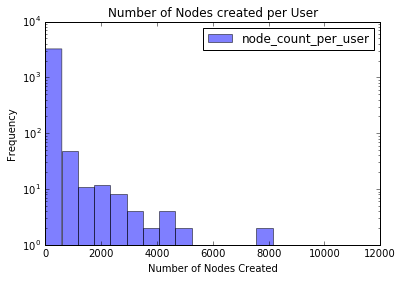

In [322]:
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

df = pd.read_csv('node_contribution_per_user.csv', header=None, names = ['node_count_per_user'])
df
ax = df.plot(kind = 'hist', title = 'Number of Nodes created per User',logy=True,alpha = 0.5, bins = 20)
ax.set(xlabel = 'Number of Nodes Created')

The histogram above showed us the contribution distribution by user. Below I have looked at the contribution distribution over time, to understand when most of the contributions to the London OSM Dataset were made.

It seems like contributions for the number of nodes in London grew steadily up to 2012 but have since declined.

[<matplotlib.text.Text at 0x230ef358>, <matplotlib.text.Text at 0x3a022080>]

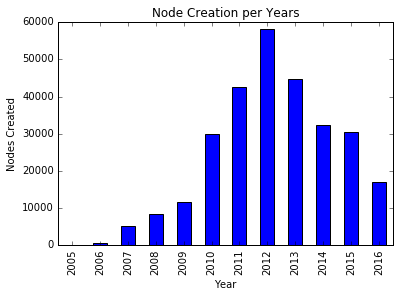

In [323]:
import csv
import re

pattern = re.compile(r'(\w+)')

data = []
with open ('date.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        row = str(row)
        result = (pattern.search(row)).group()
        data.append(result)
        
df = pd.DataFrame(data)
ax = df[0].value_counts().sort_index(axis=0, ascending=True).plot(kind = 'bar', title = 'Node Creation per Years')
ax.set(xlabel = 'Year', ylabel = 'Nodes Created')

**How many nodes on average make up a way?**

    query = "select avg(count) from (select ways_tags.id, count(node_id) as count 
            from ways_tags join ways_nodes on ways_tags.id = ways_nodes.id 
            group by ways_tags.id) as subq"

**Result:**
23.1


#### Let's now use the data to understand more about London.

**What are the ten most common amenities?**

    query = "select value, count(value) as count from nodes_tags where key = 'amenity' 
            group by value order by count desc limit 10;"

**Result:**

- post_box,334
- bench,196
- bicycle_parking,151
- pub,138
- restaurant,113
- telephone,97
- cafe,75
- waste_basket,70
- place_of_worship,65
- fast_food,62


### Additional Ideas and Conclusions included in the Report